About to rerun this but will alter the way obsids are stored, going to comment out old one and write new one in above it.  Revert if it doesn't work.

In [1]:
#Import all the tools we'll need
import pandas as pd
import geopandas as gp
import shapely as sp
from shapely.geometry import Point, Polygon, MultiPolygon
import numpy as np
from itertools import combinations
import intake
from shapely.geometry import MultiPoint

In [2]:
#Michael's code, gets the polygon of an obsid
def get_outer_polygon_for_obsid(obsid, return_hull=True):
    tiles = pd.read_csv("tile_coordinates.csv")
    obsid_tiles = tiles.query("obsid == @obsid")
    cols = "BodyFixedCoordinateX BodyFixedCoordinateY".split()
    coords = obsid_tiles[cols]
    coords.columns = ["x", "y"]
    mp = MultiPoint(list(zip(coords.x, coords.y)))
    if return_hull:
        return mp.convex_hull
    else:
        return mp

In [3]:
#My code, goes through every possible combination of polygons and gives areas
def interchecker(polygon_array):
    """
    
    """
    bucket2 = []
    combos = []
    iterable1 = range(len(polygon_array)) 
    p = len(polygon_array)
    for n in iterable1:
        if p > 0:
            comb = list(combinations(iterable1,p))
            for item in comb:
                x = item
                combos.append(x)
            p = p-1
        else:
            end

    #the above gives us an array of each possible combination eg
    #combos = [comb[0],comb[1],...]
    #where comb[0] could be (0,1,2,4) or something of the sort
    
    for ele in combos:
        d = {}
        #print(ele) #shows the element used
        #d['region_name'] = region
        #d['index_used'] = ele #for testing
        bucket = []
        for number in ele:
            bucket.append(polygon_array[number])
            #bucket now [poly0, poly1, poly2, poly4] if using comb[0] above
        d['elements_used'] = bucket
        Multi = MultiPolygon(bucket)
        d['multipolygon'] = Multi
        if len(bucket)>1:
            y = bucket[0].intersection(bucket[1])
            for i in range(len(bucket)-2):
                y = y.intersection(bucket[i+2])
            #print(y.area)
            d["combo_area"]= y.area
        else:
            #print(bucket[0].area)
            d['combo_area'] = bucket[0].area
        #for number in ele:
            #d['elements_used'] = polygon_array[number]
            #must move elements used to get every element used- where?
        bucket2.append(d)
    return pd.DataFrame(bucket2)

In [4]:
olddata = pd.read_csv("n_obj_df.csv") #old dataframe we're comparing to
#updating n_obj_df (from calculate_fractional_coverage_new notebook)

In [5]:
olddata.head() #check it loaded in correctly

,Latitude,Ls,MY,Which,fraction,n_objects,obsid,pixel_area,region_name
0,-85.4074,214.785,29,both,0.115,933,ESP_012079_0945,2.551911e+07,Macclesfield
1,-85.4065,183.727,29,both,0.070,1971,ESP_011407_0945,2.592302e+06,Macclesfield
2,-85.4056,198.040,29,both,0.072,1525,ESP_011723_0945,8.455380e+06,Macclesfield
3,-85.4049,207.892,29,both,0.168,788,ESP_011934_0945,7.357966e+06,Macclesfield
4,-85.4067,235.282,29,both,0.111,1285,ESP_012501_0945,4.882627e+06,Macclesfield


In [6]:
testregion = 'Macclesfield' #set a test region

In [7]:
#Make a smaller df with areas, obsids, polygons, and region names
bucket = []
for obs in olddata[olddata['region_name'] == testregion].obsid.unique():
    d = {}
    d['region_name'] = testregion
    d['Obsid_Used'] = obs
    x = get_outer_polygon_for_obsid(obs)
    area = x.area
    d['Obsid_Area'] = area
    d['polygon_shape'] = x
    bucket.append(d)
results = pd.DataFrame(bucket)

In [8]:
results #show what we made immediately above

,Obsid_Area,Obsid_Used,polygon_shape,region_name
0,10.754545,ESP_012079_0945,"POLYGON ((-67.69881540000002 255.7925763, -68....",Macclesfield
1,2.720774,ESP_011407_0945,"POLYGON ((-79.4964947 242.6512937, -71.7773945...",Macclesfield
2,14.759485,ESP_011723_0945,"POLYGON ((-72.54717990000002 244.8776493, -72....",Macclesfield
3,5.338690,ESP_011934_0945,"POLYGON ((-68.00317840000001 256.1826178, -68....",Macclesfield
4,5.246979,ESP_012501_0945,"POLYGON ((-67.989408 256.1117836, -68.32543100...",Macclesfield
5,6.933368,ESP_012290_0945,"POLYGON ((-66.91617959999999 257.8571416, -67....",Macclesfield
6,7.428567,ESP_011406_0945,"POLYGON ((-66.20375920000001 254.0296356, -66....",Macclesfield
7,6.965716,ESP_021494_0945,"POLYGON ((-66.8270493 258.3039062, -66.9954035...",Macclesfield
8,5.204890,ESP_020782_0945,"POLYGON ((-66.48888240000001 259.2801681, -66....",Macclesfield
9,5.208502,ESP_020716_0945,"POLYGON ((-66.41012389999999 259.1488139, -66....",Macclesfield


In [9]:
#smaller df with obs used, obsid
bucket = []
for obs in olddata[olddata['region_name'] == testregion].obsid.unique():
    d = {}
    d['obsid'] = obs #we dont want obs, want obs used in combo
    x = get_outer_polygon_for_obsid(obs)
    d['obs_poly'] = x
    bucket.append(d)
testresult = pd.DataFrame(bucket)

In [10]:
testresult.head() #see what was created immediately above

,obs_poly,obsid
0,"POLYGON ((-67.69881540000002 255.7925763, -68....",ESP_012079_0945
1,"POLYGON ((-79.4964947 242.6512937, -71.7773945...",ESP_011407_0945
2,"POLYGON ((-72.54717990000002 244.8776493, -72....",ESP_011723_0945
3,"POLYGON ((-68.00317840000001 256.1826178, -68....",ESP_011934_0945
4,"POLYGON ((-67.989408 256.1117836, -68.32543100...",ESP_012501_0945


In [11]:
df1 = testresult #rename for convenience

In [12]:
df2 = interchecker(testresult.obs_poly) #rename for convenience
#df2.head()
print(len(df2)) #check it's length (it's what we wanted it to be) 

16383


In [13]:
df2.head()
#this is the result of every possible combination of our polygons and their areas

,combo_area,elements_used,multipolygon
0,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68..."
1,0.073851,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68..."
2,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68..."
3,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68..."
4,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68..."


In [14]:
len(df1) #check length, what we expected as macclesfield has 14 hirise images

14

In [15]:
df1.head()

,obs_poly,obsid
0,"POLYGON ((-67.69881540000002 255.7925763, -68....",ESP_012079_0945
1,"POLYGON ((-79.4964947 242.6512937, -71.7773945...",ESP_011407_0945
2,"POLYGON ((-72.54717990000002 244.8776493, -72....",ESP_011723_0945
3,"POLYGON ((-68.00317840000001 256.1826178, -68....",ESP_011934_0945
4,"POLYGON ((-67.989408 256.1117836, -68.32543100...",ESP_012501_0945


In [16]:
x = 14+91+364+1001+2002+3003+3432+3003+2002+1001+364+91+14+1
print(x)#we expect this many combinations, and we get it! (= len(df2))

16383


In [17]:
Testregion_inter = interchecker(results.polygon_shape)
#run interchecker on 'results', which is every obsid in the region

In [18]:
Testregion_inter.head() #check what it looks like, looks correct

,combo_area,elements_used,multipolygon
0,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68..."
1,0.073851,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68..."
2,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68..."
3,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68..."
4,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68..."


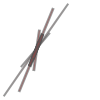

In [19]:
Testregion_inter.multipolygon[3]

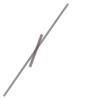

In [20]:
Testregion_inter.multipolygon[16300]

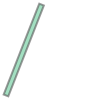

In [21]:
Testregion_inter.multipolygon[0][0]

In [22]:
results.Obsid_Area.max()

14.759485453249887

In [23]:
Testregion_inter.combo_area.max()
#the max area is still correct, nothing got made bigger at least

14.759485453249887

In [24]:
#Testregion_inter.combo_area.head()

In [25]:
bucket2 = []
for ele in Testregion_inter.index:
    #print(ele)
    polylist = Testregion_inter.elements_used[ele]
    bucket = []
    for poly in polylist:
        x = df1.obsid[df1['obs_poly'] == poly].values[0]
        bucket.append(x)
    bucket2.append(bucket)
Testregion_inter['obsids_used'] = np.array(bucket2)
#use olddata and Testregion_inter, combine so that we get a list of
#the obsids used which we add to our Testregion_inter dataframe

In [26]:
#THIS IS THE REAL ONE! Save!
# bucket2 = []
# for ele in Testregion_inter.index:
#     #print(ele)
#     polylist = Testregion_inter.elements_used[ele]
#     bucket = []
#     for poly in polylist:
#         x = df1.obsid[df1['obs_poly'] == poly].values[0]
#         bucket.append(x)
#     bucket = tuple(bucket)
#     bucket2.append(bucket)
# Testregion_inter['obsids_used'] = np.array(bucket2)


In [27]:
Testregion_inter.head() #check what we get, looks right!
#print(Testregion_inter.obsids_used[0])

,combo_area,elements_used,multipolygon,obsids_used
0,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_..."
1,0.073851,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_..."
2,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_..."
3,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_..."
4,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_..."


In [28]:
obsdf = Testregion_inter #rename this monstrosity

In [29]:
obsdf.head()

,combo_area,elements_used,multipolygon,obsids_used
0,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_..."
1,0.073851,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_..."
2,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_..."
3,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_..."
4,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_..."


In [30]:
len(obsdf)

16383

In [31]:
#this gives us the number of hirise images used in each combo
#num hirise is also num elements used, num obsids used
bucket = []
for i in range(len(obsdf.elements_used)): #change to range(len(obsdf.elements_used)) after we check
    #print(len(obsdf.elements_used[i])) #check it's what we want.
    obsdf.at[i, 'number_hirise'] = int(len(obsdf.elements_used[i]))
    #even calling it int(len) still gives float on df, but whatever.

In [32]:
obsdf.head()

,combo_area,elements_used,multipolygon,obsids_used,number_hirise
0,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",14.0
1,0.073851,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0
2,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0
3,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0
4,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0


In [33]:
#add L_s values as a list, just as we added obsids used as a list
#gives L_s values for each obsid
bucket2 = []
for obslist in obsdf.obsids_used:
    bucket = []
    for obs in obslist:
        x = olddata.Ls[olddata['obsid'] == obs].values[0]
        bucket.append(x)
    bucket = tuple(bucket)
    bucket2.append(bucket)
obsdf['Ls_used'] = np.array(bucket2)
obsdf['region_name'] = testregion

In [35]:
obsdf.head() 

,combo_area,elements_used,multipolygon,obsids_used,number_hirise,Ls_used,region_name
0,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",14.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
1,0.073851,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
2,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
3,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
4,0.008637,"[POLYGON ((-67.69881540000002 255.7925763, -68...","(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield


In [69]:
obsdf = obsdf.drop(['elements_used'], axis = 1) #drop elements_used, don't need

KeyError: "['elements_used'] not found in axis"

In [61]:
obsdf = gp.GeoDataFrame(obsdf) #turn obsdf into a geodataframe

In [62]:
obsdf = obsdf.set_geometry('multipolygon') #assign the geometry column

In [63]:
obsdf.head() #make sure it looks right

,combo_area,multipolygon,obsids_used,number_hirise,Ls_used,region_name
0,0.008637,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",14.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
1,0.073851,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
2,0.008637,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
3,0.008637,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
4,0.008637,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield


In [64]:
obsdf.to_csv('Macclesfield_duplicate_combodf.csv', index=False)
#turn this df into a csv, don't need index

In [65]:
combodf = pd.read_csv("Macclesfield_duplicate_combodf.csv")
#read in the exact same csv we created, this is obsdf read back in

In [66]:
combodf.head(2) #check our just read in file

,combo_area,multipolygon,obsids_used,number_hirise,Ls_used,region_name
0,0.008637,MULTIPOLYGON (((-67.69881540000002 255.7925763...,"['ESP_012079_0945', 'ESP_011407_0945', 'ESP_01...",14.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
1,0.073851,MULTIPOLYGON (((-67.69881540000002 255.7925763...,"['ESP_012079_0945', 'ESP_011407_0945', 'ESP_01...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield


In [71]:
obsdf.head(2) #check our original file.  Doesn't seem to match, obsdf has the proper multipolygon, this does not

,combo_area,multipolygon,obsids_used,number_hirise,Ls_used,region_name
0,0.008637,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",14.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield
1,0.073851,"(POLYGON ((-67.69881540000002 255.7925763, -68...","[ESP_012079_0945, ESP_011407_0945, ESP_011723_...",13.0,"(214.785, 183.727, 198.04, 207.892, 235.282, 2...",Macclesfield


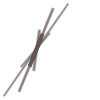

In [70]:
obsdf.multipolygon[0]

In [68]:
combodf.multipolygon[0] #oh no

'MULTIPOLYGON (((-67.69881540000002 255.7925763, -68.0397766 255.9241635, -68.2102417 255.9901059, -68.3806735 256.0561472, -66.51658209999999 260.8401089, -65.92657060000001 262.3506059, -65.7792438 262.727603, -65.4351928 263.6075048, -65.18990550000001 264.2344785, -64.9442308 264.8613011, -64.6979937 265.4875738, -64.40197689999999 266.2389609, -63.3174531 268.9907508, -63.07056650000001 269.6157661, -62.38826820000001 269.3496037, -67.5507085 256.169611, -67.6000533 256.0438146, -67.69881540000002 255.7925763)), ((-79.4964947 242.6512937, -71.77739459999999 253.8635486, -71.46847209999999 254.3115077, -70.84964120000002 255.2074994, -70.5397844 255.6551738, -70.22919159999999 256.1023187, -69.9174458 256.5497336, -56.8173104 275.3080391, -56.50581800000001 275.753868, -56.1930716 276.1998598, -55.87910890000001 276.6460092, -55.25149620000001 277.5366029, -54.9371813 277.9817438, -54.62269420000001 278.4268853, -53.6770012 279.7634786, -53.04730479999999 280.6534371, -51.4716348 2